In [1]:
from utils.metrics import *
import numpy as np

data = np.load('dataset/reconstruction/reconstructions.npz')
ground_truth = np.load('dataset/np/ellipsoid_dataset.npy')

volume_name = data['volume_name']

def get_number(name):
  return int(name.split('_')[2])

sorted_data = np.argsort([get_number(name) for name in volume_name])

volumes = data['volumes'][sorted_data]
noise_level = data['noise_level']

noised = np.where(noise_level == 0.00)[0]

reconstruction = volumes[noised]
ground_truth = np.transpose(ground_truth, (0, 3, 1, 2))

print(f'reconstruction shape: {reconstruction.shape}')
print(f'ground_truth shape: {ground_truth.shape}')

reconstruction shape: (100, 50, 256, 256)
ground_truth shape: (100, 50, 256, 256)


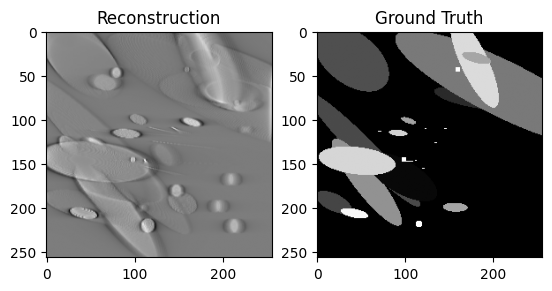

In [2]:
import matplotlib.pyplot as plt
plt.subplot(1, 2, 1); plt.imshow(reconstruction[1, 10], cmap='grey'); plt.title("Reconstruction")
plt.subplot(1, 2, 2); plt.imshow(ground_truth[1, 10], cmap='grey'); plt.title("Ground Truth")
plt.show()

In [3]:
import torch
from sklearn.model_selection import train_test_split
from utils.preprocess import normalize, split_volume

reconstruction = np.array([normalize(vol) for vol in reconstruction])
ground_truth = np.array([normalize(vol) for vol in ground_truth])

recon = []
gt = []

for i in range(len(reconstruction)):
  recon_chunk = split_volume(reconstruction[i])
  gt_chunk = split_volume(ground_truth[i])
  recon.extend(recon_chunk)
  gt.extend(gt_chunk)

reconstruction = np.array(recon)
ground_truth = np.array(gt)

print(f'reconstruction shape: {reconstruction.shape}')
print(f'ground_truth shape: {ground_truth.shape}')

train_reconstruction, test_reconstruction, train_ground_truth, test_ground_truth = train_test_split(reconstruction, ground_truth, test_size=0.2, random_state=42)

train_reconstruction = torch.FloatTensor(train_reconstruction).unsqueeze(1)  # [N, 1, D, H, W]
train_ground_truth = torch.FloatTensor(train_ground_truth).unsqueeze(1)
test_reconstruction = torch.FloatTensor(test_reconstruction).unsqueeze(1)
test_ground_truth = torch.FloatTensor(test_ground_truth).unsqueeze(1)

print(f'train_reconstruction shape: {train_reconstruction.shape}')
print(f'test_reconstruction shape: {test_reconstruction.shape}')
print(f'train_ground_truth shape: {train_ground_truth.shape}')
print(f'test_ground_truth shape: {test_ground_truth.shape}')


reconstruction shape: (500, 10, 256, 256)
ground_truth shape: (500, 10, 256, 256)
train_reconstruction shape: torch.Size([400, 1, 10, 256, 256])
test_reconstruction shape: torch.Size([100, 1, 10, 256, 256])
train_ground_truth shape: torch.Size([400, 1, 10, 256, 256])
test_ground_truth shape: torch.Size([100, 1, 10, 256, 256])


In [4]:
from utils.model import ResUnet3D
model = ResUnet3D()

In [5]:
from torch.utils.data import DataLoader, TensorDataset
from torch import optim
from utils.net_errors import Loss

train_dataset = TensorDataset(train_reconstruction, train_ground_truth)
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
test_dataset = TensorDataset(test_reconstruction, test_ground_truth)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

criterion = Loss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-6)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(20):
    # Training
    model.train()
    train_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            val_loss += criterion(outputs, targets).item()

    print(f"Epoch {epoch+1}, Train Loss: {train_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(test_loader):.4f}")

Epoch 1, Train Loss: 5.7723, Val Loss: 6.1961
Epoch 2, Train Loss: 5.5045, Val Loss: 6.0711
Epoch 3, Train Loss: 5.4015, Val Loss: 5.8587
Epoch 4, Train Loss: 5.2853, Val Loss: 5.8261
Epoch 5, Train Loss: 5.1050, Val Loss: 6.3629
Epoch 6, Train Loss: 4.8538, Val Loss: 5.7599
Epoch 7, Train Loss: 4.6457, Val Loss: 5.2231
Epoch 8, Train Loss: 4.4678, Val Loss: 4.9684
Epoch 9, Train Loss: 4.3387, Val Loss: 4.7982
Epoch 10, Train Loss: 4.2187, Val Loss: 4.9370
Epoch 11, Train Loss: 4.1243, Val Loss: 4.9716
Epoch 12, Train Loss: 4.0423, Val Loss: 4.4663
Epoch 13, Train Loss: 3.9660, Val Loss: 4.3654
Epoch 14, Train Loss: 3.8509, Val Loss: 4.3622
Epoch 15, Train Loss: 3.8151, Val Loss: 4.3130
Epoch 16, Train Loss: 3.7264, Val Loss: 4.1427
Epoch 17, Train Loss: 3.6731, Val Loss: 4.4846
Epoch 18, Train Loss: 3.6085, Val Loss: 4.0020
Epoch 19, Train Loss: 3.5578, Val Loss: 4.1014
Epoch 20, Train Loss: 3.5171, Val Loss: 3.9938


PSNR: 4.40 dB, SSIM: -0.0232


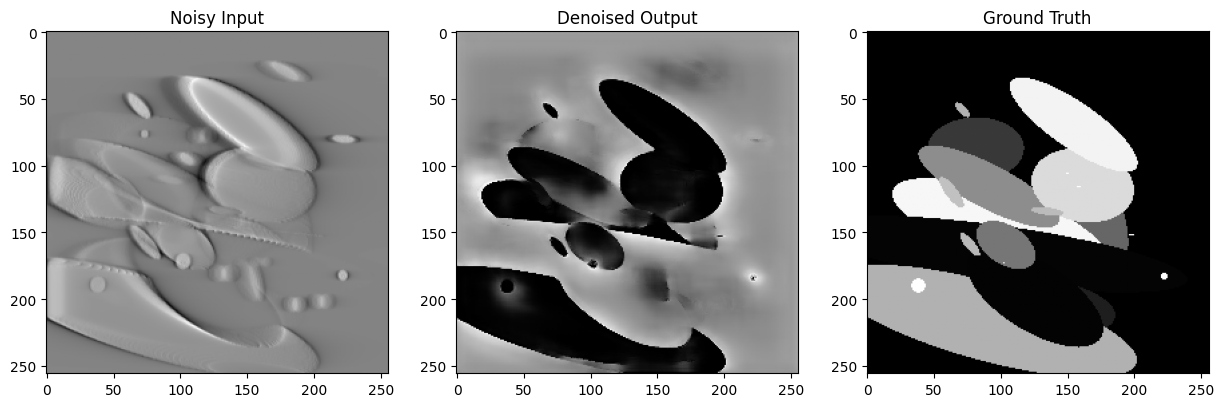

In [9]:
model.eval()
i = 2
with torch.no_grad():
    # Select a test volume
    test_input = test_reconstruction[i:i+1].to(device)
    test_output = model(test_input)
    test_target = test_ground_truth[i:i+1].to(device)

    # Convert to numpy
    input_slice = test_input.squeeze().cpu().numpy()[5]  # Middle slice (D/2)
    output_slice = test_output.squeeze().cpu().numpy()[5]
    target_slice = test_target.squeeze().cpu().numpy()[5]

    # Compute metrics
    from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
    #p = psnr(target_slice, output_slice, data_range=1.0)
    ssim = ssim(target_slice, output_slice, data_range=1.0)

    psnr = PSNR(target_slice, output_slice)
    #ssim = SSIM(target_slice, output_slice)

    print(f"PSNR: {psnr:.2f} dB, SSIM: {ssim:.4f}")

    # Plot
    import matplotlib.pyplot as plt
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(input_slice, cmap='gray')
    plt.title("Noisy Input")
    plt.subplot(1, 3, 2)
    plt.imshow(output_slice, cmap='gray')
    plt.title("Denoised Output")
    plt.subplot(1, 3, 3)
    plt.imshow(target_slice, cmap='gray')
    plt.title("Ground Truth")
    plt.show()

In [10]:
# save model
torch.save(model.state_dict(), 'models/model_7.pth')